In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from collections import Counter
from itertools import combinations
from IPython.display import Image

import scipy.stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.outliers_influence import variance_inflation_factor


import sklearn.metrics as metrics
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_validate, cross_val_score

from sklearn.svm import SVR
from xgboost import  XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


plt.rcParams['font.family'] = 'Malgun Gothic'   
plt.rc('axes', unicode_minus=False)
plt.rcParams['font.size'] = 16                  
plt.rcParams['figure.figsize'] = 8, 5  
plt.rcParams['axes.unicode_minus'] = False    

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data1.csv', encoding = 'euc-kr' , index_col = 'Unnamed: 0' )
df.drop(['발생일'], axis = 1, inplace = True)

### 연속형 변수에 대한 EDA

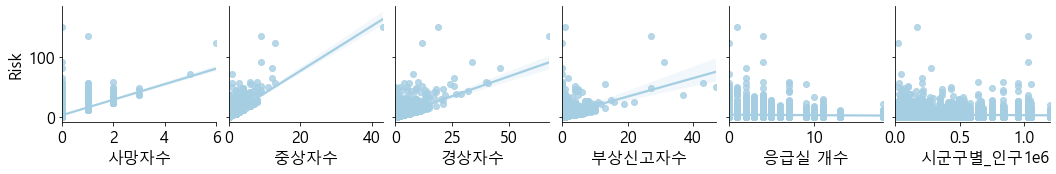

In [3]:
sb.set_palette('Paired')
sb.pairplot(df, y_vars = 'Risk', x_vars = list(df.columns)[-7:-1], kind="reg")
plt.show()

### 상관분석
- **Step 1. Pearson 상관계수 및 Heatmap을 통한 상관분석 실시** 
    - 변수(feature)들의 상관관계를 고려하기 위해 DataFrame.corr() 함수 : default = Pearson을 이용하여 heatmap으로 표시한 결과, 사망자수, 중상자수, 경상자수, 부상신고자수 feature가 Risk(Target)에 영향을 가장 크게 끼쳤다.
    
    - Step1의 분석 및 문제
        - Risk 계산시 위 4가지 변수에 대한 가중치 값의 합을 이용하였으므로, 예상된 결과라고 생각되며, 다중공선성 문제를 야기시킬 수 있는           변수로 모델링시 제거할 필요가 있다.
        - 명목변수 데이터 간의 상관분석은 Pearson 상관계수로는 올바른 관계 해석이 이루어질 수 없으므로, 명목 변수간의 관계를 파악할 수 있           는 lambda 계수를 추가적으로 활용할 필요가 있다.
<br><br>
- **Step 2. lambda 계수를 통한 상관분석 실시** 
    - lambda 계수의 정의  : 명목변수들 간 상관관계의 크기를 나타내는 계수. 일명 거트만(Guttman) 상관계수.

#### Step 1. Pearson 상관계수 및 Heatmap을 통한 상관분석 실시

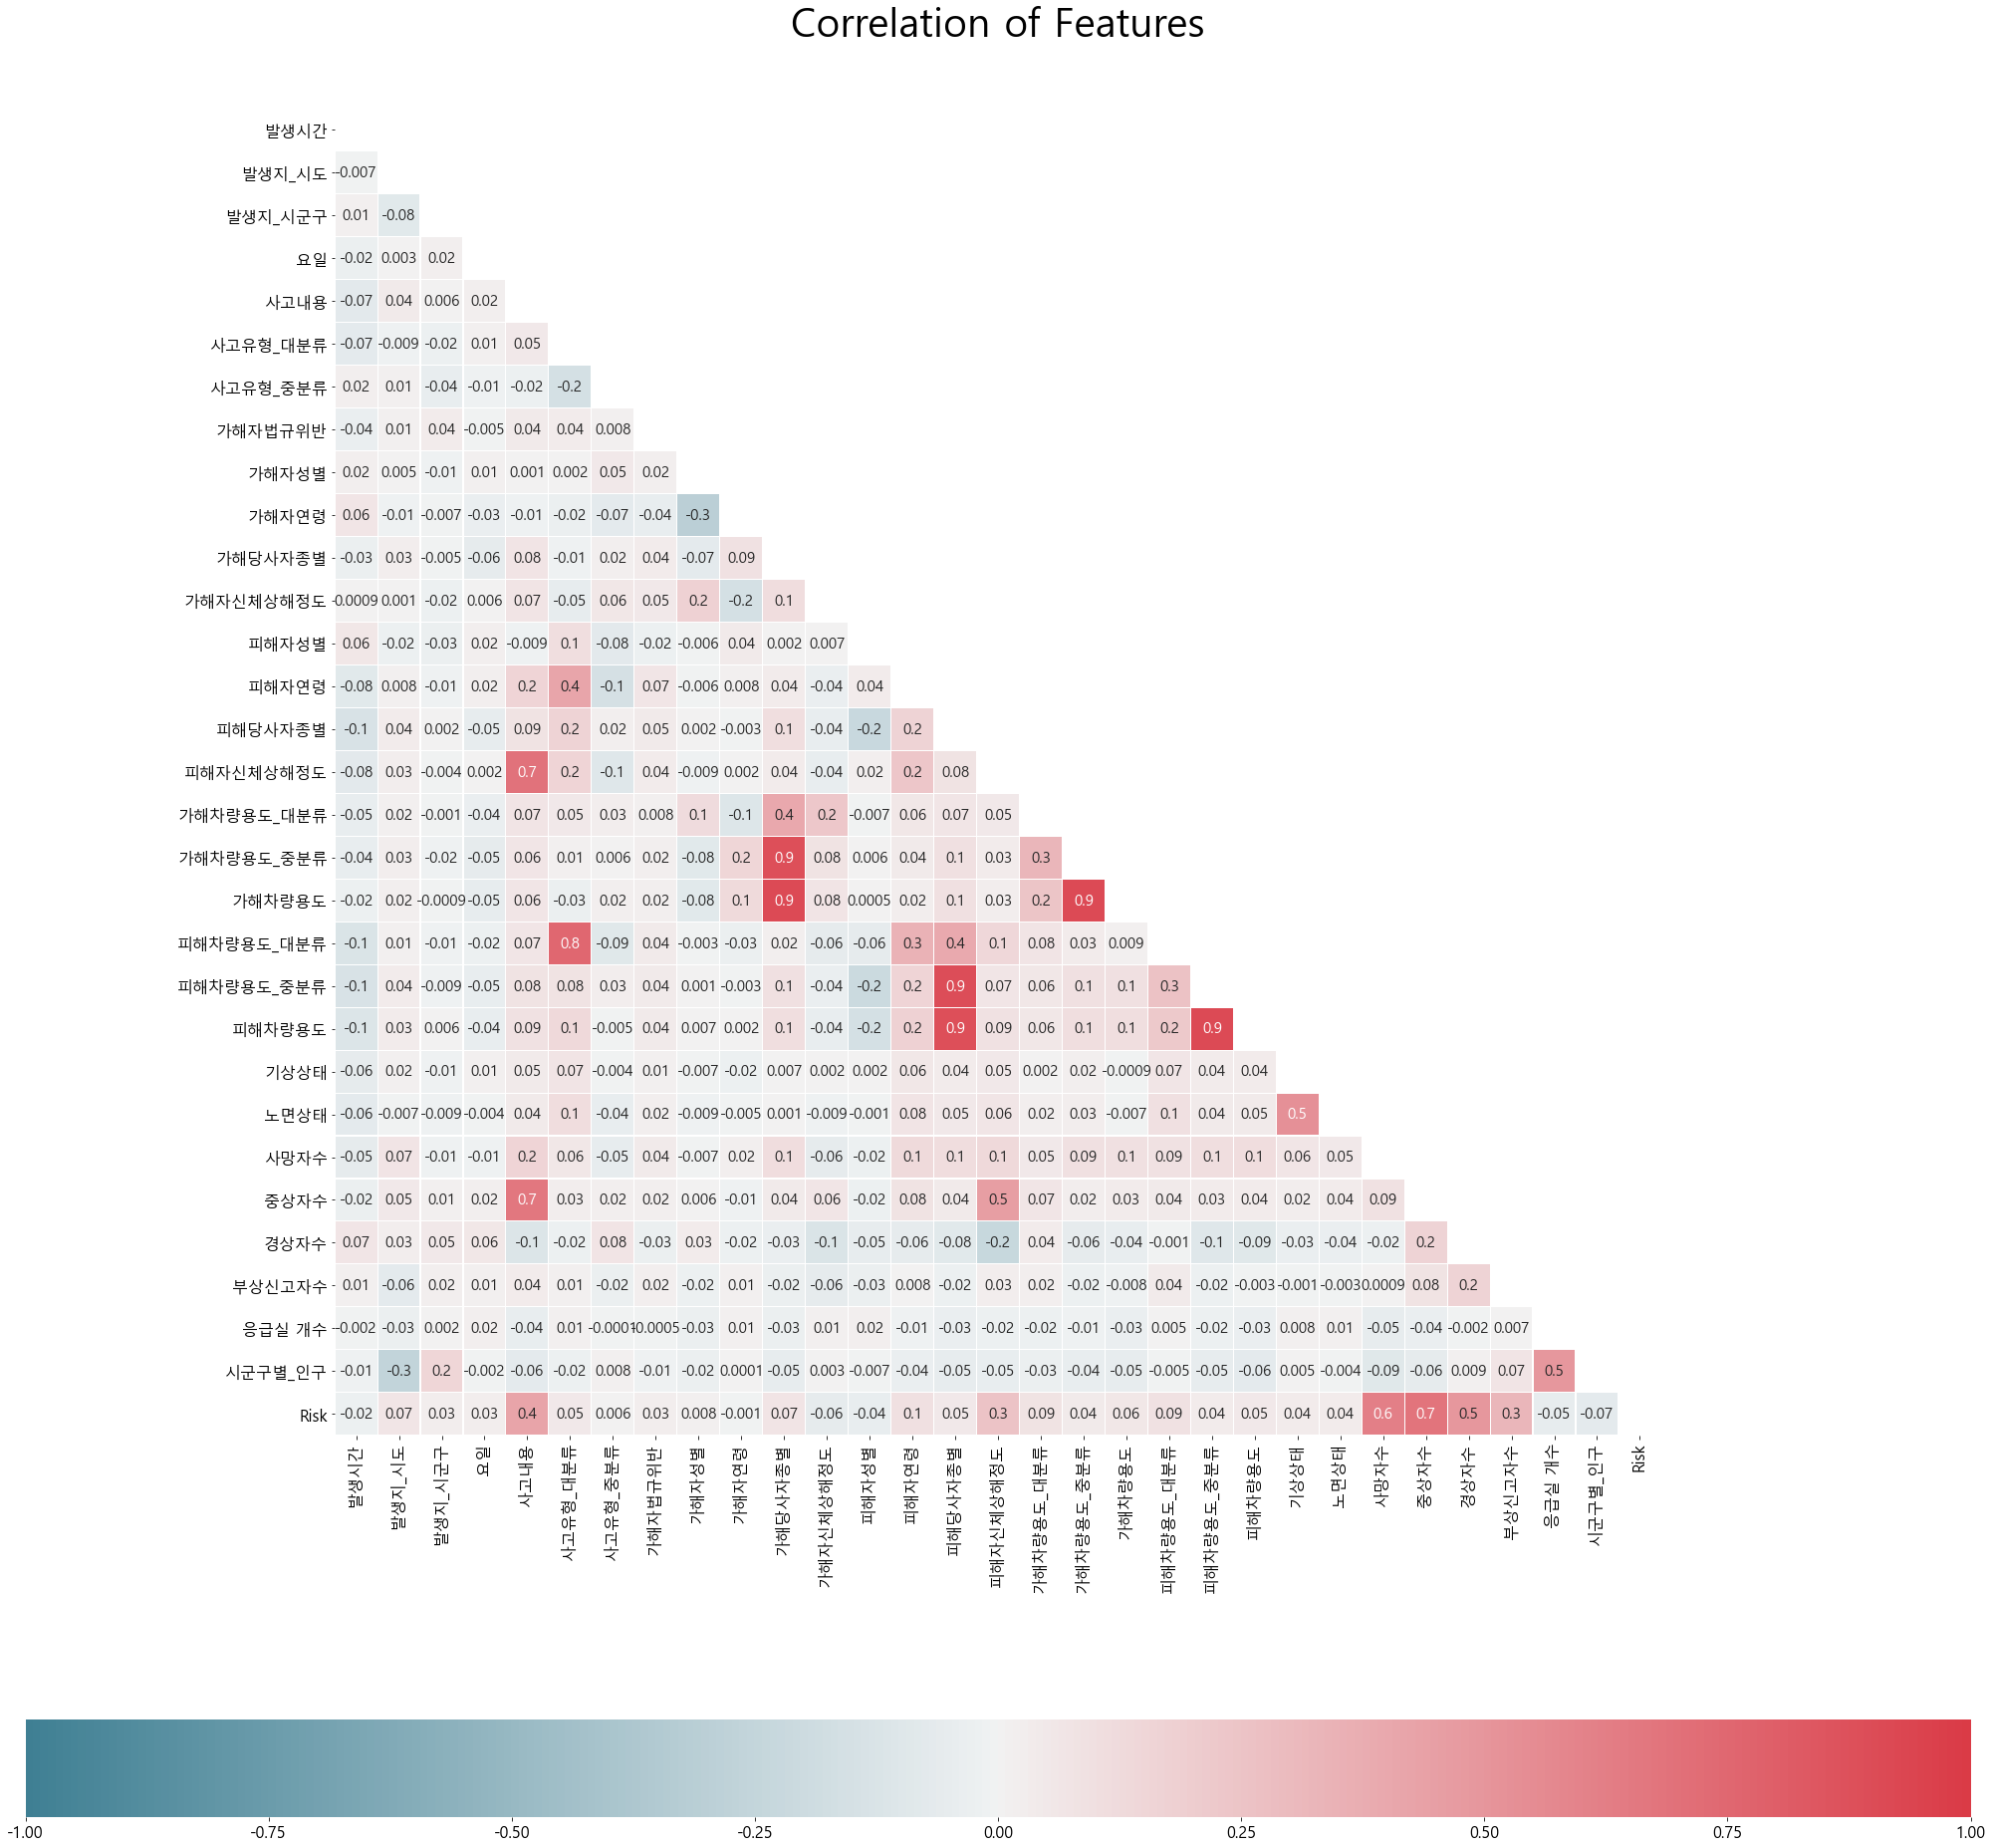

In [4]:
f, ax  = plt.subplots(figsize=(35,35))
matrix = np.triu(df.corr())

plt.title("Correlation of Features", y = 1.05, size = 40) 
colormap = sb.diverging_palette(220, 10, as_cmap = True)
sb.heatmap(df.corr(),
           annot = True, annot_kws = {"size": 15}, fmt ='.1g', linewidths = 0.1, 
           center = 0, vmin = -1, vmax = 1,  linecolor = "white", 
           cmap = colormap, cbar = True, cbar_kws = {'orientation': 'horizontal'} , 
           square = True, mask = matrix)
plt.show()

#### Step 2. lambda 계수를 통한 상관분석 실시
- 명목 변수간의 다중공선성을 일으킬 수 있을 만한 요인을 탐색.
- 두 명목변수 간의 쌍에 대한 상관관계가 0.8이상인 모든 조합의 수를 탐색한 후, 가장 많이 등장한 변수명에 대한 빈도 시각화 수행.
<br><br>
- **명목변수 간의 상관관계가 높아 다중공선성을 일으킬 수 있는 변수 목록**
    - [발생시간, 발생시_시군구, 사고유형_대분류, 가해자법규위반, 가해자성별, 가해 당사자 종별, 피해자 성별, 피해당사자종별, 가해자차량용도_중분류, 가해자차량용도_대분류, 피해자차량용도_대분류, 기상상태. 가해자차량용도, 피해자차량용도, 피해자차량용도_중분류]

In [5]:
def lambda_coefficient(data) :
    max_column  = np.max(data.sum(axis=0))
    denominator = np.sum(data.sum()) - max_column
    numerator   = data.apply(lambda x: np.sum(x)- np.max(x), axis=1)
    numerator   = np.sum(numerator)
    return round(numerator/denominator, 4)

In [6]:
low_coef = []
for i , j in list(combinations(df.iloc[:,:-7].columns, 2)) :
    data = df[[i, j]]
    coef = lambda_coefficient(data)
    if coef > 0.8 :
        print(f'{i}와 {j}의 람다 상관 계수값 : {coef}')
        s = i + '와 '+ j
        low_coef.append(s)

발생시간와 발생지_시도의 람다 상관 계수값 : 0.8271
발생시간와 발생지_시군구의 람다 상관 계수값 : 0.9634
발생시간와 요일의 람다 상관 계수값 : 0.9308
발생시간와 사고내용의 람다 상관 계수값 : 0.9349
발생시간와 사고유형_대분류의 람다 상관 계수값 : 0.9678
발생시간와 사고유형_중분류의 람다 상관 계수값 : 0.8362
발생시간와 가해자법규위반의 람다 상관 계수값 : 0.9235
발생시간와 가해자성별의 람다 상관 계수값 : 0.97
발생시간와 가해자연령의 람다 상관 계수값 : 0.9438
발생시간와 가해당사자종별의 람다 상관 계수값 : 0.9187
발생시간와 가해자신체상해정도의 람다 상관 계수값 : 0.9358
발생시간와 피해자성별의 람다 상관 계수값 : 0.9655
발생시간와 피해자연령의 람다 상관 계수값 : 0.9246
발생시간와 피해당사자종별의 람다 상관 계수값 : 0.8751
발생시간와 피해자신체상해정도의 람다 상관 계수값 : 0.8969
발생시간와 가해차량용도_대분류의 람다 상관 계수값 : 0.9509
발생시간와 가해차량용도_중분류의 람다 상관 계수값 : 0.818
발생시간와 피해차량용도_대분류의 람다 상관 계수값 : 0.9333
발생시간와 기상상태의 람다 상관 계수값 : 0.9494
발생시간와 노면상태의 람다 상관 계수값 : 0.9007
발생지_시도와 발생지_시군구의 람다 상관 계수값 : 0.9785
발생지_시도와 사고유형_대분류의 람다 상관 계수값 : 0.9399
발생지_시도와 가해자성별의 람다 상관 계수값 : 0.9012
발생지_시도와 피해자성별의 람다 상관 계수값 : 0.8069
발생지_시도와 가해차량용도의 람다 상관 계수값 : 0.8067
발생지_시도와 피해차량용도의 람다 상관 계수값 : 0.8759
발생지_시군구와 요일의 람다 상관 계수값 : 0.9899
발생지_시군구와 사고내용의 람다 상관 계수값 : 0.9949
발생지_시군구와 사고유형_대분류의 람다 상관 계수값 : 0.9972
발생지_시군구와 사고유형_중분

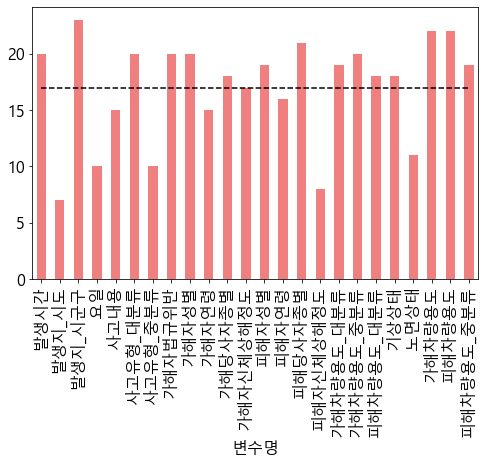

In [7]:
variable_dic = []
for i in range(len(low_coef)) :
    variable_dic += [low_coef[i].split('와')[0].strip()]
    variable_dic += [low_coef[i].split('와')[-1].strip()]
    
variable = []
count    = []
for i, j in Counter(variable_dic).items() :
    variable.append(i)
    count.append(j)

variable_df           = pd.DataFrame()
variable_df['변수명'] = variable
variable_df['빈도']   = count
variable_df.index     = variable_df['변수명']
variable_df.drop(['변수명'], axis = 1, inplace = True)
bar_list = variable_df.plot.bar(y = "빈도", legend = False, color = 'lightcoral')
plt.plot([0, 23], [variable_df.mean(), variable_df.mean()], 'k--')
plt.show()

### 통계적 모델링(OLS)
- 종속변수(Risk : 연속형 데이터) ~ 설명변수(모든 변수 포함) : 연속형 데이터 +  범주형 데이터 
    - LSE 방법론을 활용한 다중 회귀 분석 실시
    - 변수 선택 방법론으로서 후진제거법 이용.
    - Full model로부터 시작.
<br><br>
- 분석 결과 및 해석
    - 결정계수(R - squared) : 0.217(약 22%)의 설명력을 가짐.
    - 수정된 결정계수(Adj. R-squared) : 0.216(약 22%)의 설명력을 가짐.
    - 모델에 대한 가설 검정
        - F-statistic : 132.8
        - P-value(F-statistic) : 0.00
        - 유의수준 0.05에서 P값이 충분히 작으므로 모델은 유의미하다고 볼 수 있다.
        - 그러나 모델에 대한 설명력이 매우 낮아 사용하기는 어려울 것으로 판단된다.
    - 유의수준 5%에서 유의미하지 않은 변수.
        - [가해자법규위반, 가해자연령, 기상상태, 노면상태, 응급실 개수

In [8]:
# OLS 과정에서 변수 하나를 제대로 인식하지 못하여 변수명 재설정.()
df.columns = list(df.columns)[:-3] + ['응급실_개수', '시군구별_인구',  'Risk']
df1 = df.drop(['사망자수', '중상자수', '경상자수', '부상신고자수'], axis = 1)

In [9]:
linear_model = smf.ols(formula = 'Risk ~' + '+'.join(df1.columns[:-1]),  data = df1)
result = linear_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Risk   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     132.8
Date:                Tue, 17 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:12:38   Log-Likelihood:                -36973.
No. Observations:               12448   AIC:                         7.400e+04
Df Residuals:                   12421   BIC:                         7.420e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0692      0.500     -2.139      0.032      -2.049      -0.089
발생시간           0.0160      0.007      2.262      0.024       0.002       0.030
발생지_시도         0.0458      0.009      5.367      0.000       0.029       0.063
발생지_시군구        0.0027      0.001      2.816      0.005       0.001       0.005
요일             0.0720      0.021      3.442      0.001       0.031       0.113
사고내용           1.9210      0.044     43.894      0.000       1.835       2.007
사고유형_대분류      -1.2494      0.296     -4.221      0.000      -1.830      -0.669
사고유형_중분류       0.0194      0.009      2.133      0.033       0.002       0.037
가해자법규위반        0.0385      0.046      0.835      0.404      -0.052       0.129
가해자성별          0.2356      0.116      2.035      0.042       0.009       0.462
가해자연령          0.0313      0.028      1.138      0.255      -0.023       0.085
가해당사자종별        0.1067      0.052      2.052      0.040       0.005       0.209
가해자신체상해정도     -0.4889      0.036    -13.426      0.000      -0.560      -0.417
피해자성별         -0.2308      0.056     -4.139      0.000      -0.340      -0.122
피해자연령          0.1038      0.031      3.393      0.001       0.044       0.164
피해당사자종별       -0.1355      0.049     -2.758      0.006      -0.232      -0.039
피해자신체상해정도     -0.2313      0.024     -9.468      0.000      -0.279      -0.183
가해차량용도_대분류     0.7792      0.096      8.102      0.000       0.591       0.968
가해차량용도_중분류    -0.1783      0.027     -6.576      0.000      -0.231      -0.125
가해차량용도         0.1187      0.027      4.378      0.000       0.066       0.172
피해차량용도_대분류     0.9703      0.123      7.894      0.000       0.729       1.211
피해차량용도_중분류    -0.1220      0.026     -4.688      0.000      -0.173      -0.071
피해차량용도         0.1283      0.024      5.431      0.000       0.082       0.175
기상상태           0.1001      0.079      1.274      0.203      -0.054       0.254
노면상태           0.0621      0.041      1.518      0.129      -0.018       0.142
응급실_개수        -0.0235      0.016     -1.434      0.152      -0.056       0.009
시군구별_인구    -3.221e-07   1.58e-07     -2.033      0.042   -6.33e-07   -1.15e-08
==============================================================================
Omnibus:                    18394.266   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15206092.117
Skew:                           8.730   Prob(JB):                         0.00
Kurtosis:                     173.331   Cond. No.                     6.52e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 다중공선성 확인

In [10]:
df2 = df1.drop(['Risk'], axis=1)
vif1 = pd.DataFrame()
vif1["Features"]   = df2.columns
vif1["VIF"] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
vif1.sort_values("VIF", inplace=True, ascending = False)
vif1.round(3)

,Features,VIF
19,피해차량용도_대분류,84.472
21,피해차량용도,57.636
18,가해차량용도,55.407
5,사고유형_대분류,53.982
20,피해차량용도_중분류,43.907
14,피해당사자종별,43.529
17,가해차량용도_중분류,39.430
10,가해당사자종별,34.362
16,가해차량용도_대분류,25.187
7,가해자법규위반,21.384


### 후진제거법(Backward Elimination)
- 모든 변수가 포함된 모형으로부터 불필요한 독립변수들을 하나씩 제거해 나가는 과정을 반복하며 모형을 단순화해 나가는 방법.
- 설명변수를 모두 포함한 완전모형(Full model)에서 설명력(상관)이 가장 작은 설명변수부터 하나씩 제거하는 방법.

In [11]:
Target  = df1['Risk']
Feature = df1.iloc[:,:-1]
print(Feature.shape, Target.shape)

(12448, 26) (12448,)


In [12]:
model = LinearRegression()
rfe   = RFE(estimator = model, n_features_to_select = int(Feature.shape[-1] / 2)).fit(Feature, Target)
selected_cols = Feature.columns[rfe.support_]
removed_cols  = Feature.columns[~rfe.support_]
print(f'Selected Variables : {list(selected_cols)}')
print()
print(f'Removed Variables  : {list(removed_cols)}')

Selected Variables : ['사고내용', '사고유형_대분류', '가해자성별', '가해자신체상해정도', '피해자성별', '피해당사자종별', '피해자신체상해정도', '가해차량용도_대분류', '가해차량용도_중분류', '가해차량용도', '피해차량용도_대분류', '피해차량용도', '기상상태']

Removed Variables  : ['발생시간', '발생지_시도', '발생지_시군구', '요일', '사고유형_중분류', '가해자법규위반', '가해자연령', '가해당사자종별', '피해자연령', '피해차량용도_중분류', '노면상태', '응급실_개수', '시군구별_인구']


### 종속 변수에 영향을 주는 중요 변수 파악
- **양의 영향을 주는 변수**
    - [사고내용, 피해차량용도_대분류, 가해자차량용도_대분류, 가해자성별, 가해자차량용도, 피해자차량용도]
<br><br>

- **음의 영향을 주는 변수**
    - [사고유형_대분류, 가해자 신체상해정도, 피해자성별, 피해자신체상해정도, 피해당사자종별, 가해차량용도_중분류]

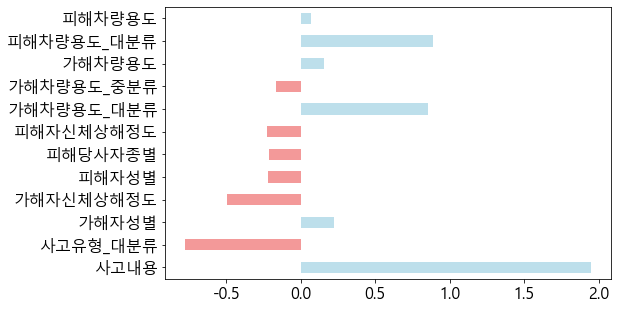

In [13]:
rfe_linear_model = smf.ols(formula = 'Risk~' + '+'.join(list(selected_cols[:-1])), data = df1)
rfe_linear_model.fit().summary()


linear_coef = pd.DataFrame({"Cofficient" : rfe_linear_model.fit().params.values[1:]},
                           index = selected_cols[:-1])
linear_coef['Positive'] = linear_coef['Cofficient'] > 0 
linear_coef['Cofficient'].plot.barh(y = "Cofficient", legend = False, alpha = .8,  
                                  color = linear_coef['Positive'].map({True : 'lightblue', False : 'lightcoral'}))
plt.show()

#### 표준화 회귀계수 사용
- 각 변수에 대한 단위가 서로 다르므로 이에 대한 올바른 영향력을 평가하기 위해 데이터를 **정규화*(Scaling)**하여 이용.

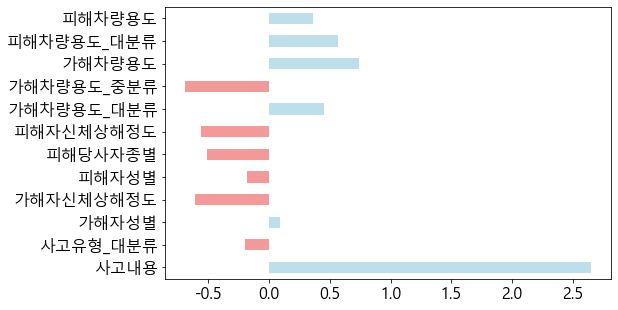

In [14]:
scaler  = StandardScaler()
cols    = Feature.columns
np_scaled = scaler.fit_transform(Feature)
df_scaled = pd.DataFrame(np_scaled, columns=cols)
df_scaled['Risk'] = Target
# df_scaled.head()

rfe_linear_scaled_model = smf.ols(formula = 'Risk~' + '+'.join(list(selected_cols[:-1])), data = df_scaled)
rfe_linear_scaled_model.fit().summary()

linear_scaled_coef = pd.DataFrame({"Cofficient" : rfe_linear_scaled_model.fit().params.values[1:]},
                                   index = selected_cols[:-1])
linear_scaled_coef['Positive'] = linear_coef['Cofficient'] > 0 
linear_scaled_coef.plot.barh(y = "Cofficient", legend = False, alpha = .8,
                            color = linear_scaled_coef['Positive'].map({True : 'lightblue', False : 'lightcoral'}))
plt.show()

### 다중공선성 재확인
- 위 lambda 계수를 통해 살펴본 다중공선성을 일으킬 가능성이 있는 변수 목록안에 VIF 값이 15 이상인 것이 존재.
    - [발생시간, 발생시_시군구, **사고유형_대분류**, 가해자법규위반, 가해자성별, 가해 당사자 종별, 피해자 성별, **피해당사자종별**, **가해자차량용도_중분류**, **가해자차량용도_대분류**, **피해차량용도_대분류**, 기상상태. 가해자차량용도, **피해차량용도**, 피해자차량용도_중분류]

In [15]:
df3 = df1[list(selected_cols)]
vif2 = pd.DataFrame()
vif2["Features"]   = df3.columns
vif2["VIF"] = [variance_inflation_factor(df3.values, i) for i in range(df3.shape[1])]
vif2.sort_values("VIF", inplace=True, ascending = False)
vif2.round(3)

,Features,VIF
10,피해차량용도_대분류,75.896
1,사고유형_대분류,48.625
11,피해차량용도,37.187
5,피해당사자종별,36.888
9,가해차량용도,36.881
8,가해차량용도_중분류,35.233
7,가해차량용도_대분류,21.477
12,기상상태,11.233
3,가해자신체상해정도,9.709
2,가해자성별,8.674


- 가해차량용도_대분류, 피해차량용도_대분류 변수는 다중공선성의 문제를 일으켜 추후 학습시 과적합을 야기할 가능성도 있지만, 
동시에 종속변수(Target)에 큰 영향을 끼치는 변수이므로 포함시켜보기로 함.

In [83]:
df4 = df1[['기상상태', '가해자신체상해정도', '가해자성별', '피해자성별', '피해자신체상해정도', '사고내용', '노면상태', '발생지_시군구',
           '가해차량용도_대분류', '피해차량용도_대분류', '가해차량용도', '응급실_개수', '시군구별_인구', '피해자연령', '요일', '가해자연령'
          , '발생시간', '피해차량용도_중분류', '가해자법규위반', '사고유형_중분류', '발생지_시도']]
df5 = df[list(df4.columns) + ['사망자수', '중상자수', '경상자수', '부상신고자수']]

vif3 = pd.DataFrame()
vif3["Features"]   = df5.columns
vif3["VIF"] = [variance_inflation_factor(df5.values, i) for i in range(df5.shape[1])]
vif3.sort_values("VIF", inplace=True, ascending = False)
vif3.round(3)

,Features,VIF
9,피해차량용도_대분류,27.721
8,가해차량용도_대분류,21.198
18,가해자법규위반,21.190
0,기상상태,15.855
1,가해자신체상해정도,10.445
2,가해자성별,9.300
10,가해차량용도,7.025
17,피해차량용도_중분류,6.604
13,피해자연령,6.192
16,발생시간,5.252


### 잔차 확인
- Q-Q plot을 통한 잔차의 정규성을 확인.
- 잔차의 형태가 비선형을 보이는 것으로 보아 정규성을 만족하고 있다고 판단하기 어렵다.
- 따라서 위 모델은 다중 회귀 분석의 가정을 위배하고 있으므로, 적절한 판단의 근거로 사용하기 어렵다고 볼 수 있다.
- 오차의 정규성과 등분산성을 고려치 않아도 되는 일반화 선형 회귀(Generalized Linear Regression)를 이용토록 한다.

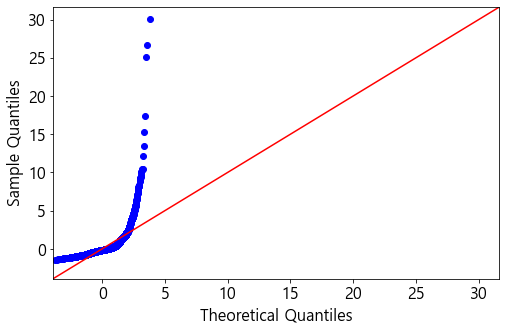

In [17]:
fig = sm.qqplot(result.resid, fit = True, line = '45')

###  포아송 회귀 모형
- 반응변수 Risk를 사고 건수와 같은 Count 지표로서 고려한 포아송 회귀 분석을 이용.
- 포아송 분포는 분산과 평균이 모두 같다는 성질을 가짐.
- 진단문제는 포아송 분포로 예측되는 것보다 종속변수의 분산이 클 때 발생할 수 있음.
- 따라서 과대산포 검정 시행한 결과 p-value가 유의수준 5%하에서 과대산포가 아닐 것이라는 귀무가설을 기각하므로 과대산포가 발생했다고 볼 수 있음.
- 이와 같이 과대산포(Overdispersion) 문제가 있는 경우, 이를 해결하지 않으면 모형에서 유의성 검사 결과를 믿을 수 없으므로 유사포아송(Quasipoisson) 이용 혹은 다른 대안을 찾는 것이 적절하다고 판단함.

In [5]:
glm_poisson = glm(Risk ~., df, family = poisson(link="log"))
summary(glm_poisson)


Call:
glm(formula = Risk ~ ., family = poisson(link = "log"), data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-26.0517   -0.8023   -0.5128    0.3045    7.0402  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.241e+02  3.878e+01  -3.201  0.00137 ** 
X                   -1.774e-05  4.373e-06  -4.057 4.97e-05 ***
발생일               6.169e-06  1.923e-06   3.208  0.00134 ** 
발생시간             4.476e-03  7.590e-04   5.897 3.71e-09 ***
발생지_시도          8.571e-03  8.811e-04   9.728  < 2e-16 ***
발생지_시군구        8.236e-04  1.042e-04   7.903 2.71e-15 ***
요일                 9.489e-03  2.285e-03   4.153 3.29e-05 ***
사고내용             3.716e-01  4.365e-03  85.120  < 2e-16 ***
사고유형_대분류     -3.271e-02  2.991e-02  -1.093  0.27423    
사고유형_중분류      1.123e-02  1.037e-03  10.824  < 2e-16 ***
가해자법규위반      -3.288e-03  4.858e-03  -0.677  0.49852    
가해자성별           8.943e-02  1.300e-02   6.881 5.96e-12 ***
가해자연령           1.

In [ ]:
glm_poisson = glm(Risk ~., df, family = poisson(link="log"))
summary(glm_poisson)

#### 과대산포 과정
- **object :**  a fitted Poisson GLM of class "glm" as fitted by glm with family poisson.
- **trafo :**  a specification of the alternative (see also details), can be numeric or a (positive) function or NULL (the default).
- **alternative :** a character string specifying the alternative hypothesis: "greater" corresponds to overdispersion, "less" to underdispersion and "two.sided" to either one.

$$H_{0} : c = 1 $$
$$H_{1} : c > 1$$

In [16]:
dispersiontest(glm_poisson)


	Overdispersion test

data:  glm_poisson
z = 6.4609, p-value = 5.205e-11
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  1.323801 


### 모델링(Modeling)
- 2017 ~ 2018년 데이터 = Train dataset
- 2019년 데이터 = Test dataset : 검증용이자, 미래 Risk(위험도) 예측용

#### 데이터셋 분할하기
- Train : Test = 66 : 34

In [104]:
df_scaled

,발생시간,발생지_시도,발생지_시군구,요일,사고내용,사고유형_대분류,사고유형_중분류,가해자법규위반,가해자성별,가해자연령,...,가해차량용도_중분류,가해차량용도,피해차량용도_대분류,피해차량용도_중분류,피해차량용도,기상상태,노면상태,응급실_개수,시군구별_인구,Risk
0,-2.078625,-0.338750,-1.346069,0.487983,1.449666,-0.082658,0.585652,0.510556,-0.214442,-0.711803,...,-0.459190,-0.399622,-0.404834,-0.394538,-0.333307,-0.288439,-0.352622,-0.044118,-0.054051,25
1,-1.751420,1.781873,1.555550,0.487983,0.713928,-0.082658,0.585652,0.510556,-0.214442,-0.111578,...,-0.459190,-0.399622,-0.404834,-0.394538,-0.333307,-0.288439,-0.352622,-0.707384,-1.036107,13
2,-1.587817,-0.338750,-0.341663,0.487983,-0.757547,-0.082658,-1.500539,0.510556,-0.214442,-0.711803,...,0.023417,0.446381,1.155345,-1.278603,-1.481766,-0.288439,-0.352622,-0.375751,-1.037276,2
3,-1.424215,0.625170,-1.212148,0.487983,-0.021810,-0.082658,0.794271,-2.730894,-2.776222,2.289323,...,-0.700493,-0.611123,1.155345,-1.278603,-1.481766,-0.288439,2.906055,-0.707384,-0.628123,1
4,-0.933407,-0.917102,-1.837112,0.487983,-0.757547,-0.082658,0.585652,0.510556,2.347338,-1.312028,...,-0.459190,-0.399622,-0.404834,-0.394538,-0.333307,-0.288439,-0.352622,0.287515,-0.691069,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,0.866221,0.046818,-0.921986,1.471536,1.449666,-0.082658,0.794271,0.510556,-0.214442,-0.111578,...,-0.459190,-0.399622,-0.404834,-0.394538,-0.333307,-0.288439,-0.352622,0.950781,0.413807,3
12444,1.029823,-0.724318,1.399309,1.471536,-0.757547,-0.082658,-1.500539,0.510556,-0.214442,1.689098,...,-0.459190,-0.399622,1.155345,-1.278603,-1.481766,-0.288439,-0.352622,-1.039018,-0.569323,1
12445,1.029823,-0.724318,1.399309,1.471536,-0.757547,-0.082658,-1.500539,0.510556,-0.214442,1.689098,...,-0.459190,-0.399622,-0.404834,-0.394538,-0.333307,-0.288439,-0.352622,-1.039018,-0.569323,1
12446,1.029823,-0.724318,1.600190,1.471536,-0.757547,-0.082658,-1.500539,-0.569927,-0.214442,-1.312028,...,-0.459190,-0.399622,1.155345,0.931560,1.197972,-0.288439,-0.352622,0.287515,0.971183,5


In [121]:
x_data = df_scaled[list(df4.columns)]
y_data = df_scaled.iloc[:, -1]
# x_train, x_test, y_train, y_test = train_test_split(df_scaled , y_data, test_size = 0.3, random_state = 2021)
# 2017 ~ 2018
x_train = df[:8225].iloc[:, :-1]
y_train = df[:8225].iloc[:, -1]

# 2019
x_test  = df[8225:].iloc[:, :-1]
y_test  = df[8225:].iloc[:, -1]
print(f'train data x size : {x_train.shape}')
print(f'train data y size : {y_train.shape}')
print(f'test data x size  : {x_test.shape}')
print(f'test data y size  : {y_test.shape}')
print()
print(f'test data ratio : {round(len(x_test) / len(df), 2) * 100}%')

train data x size : (8225, 30)
train data y size : (8225,)
test data x size  : (4223, 30)
test data y size  : (4223,)

test data ratio : 34.0%


In [ ]:
x_data = df_scaled[list(df4.columns)]
y_data = df_scaled.iloc[:, -1]
# x_train, x_test, y_train, y_test = train_test_split(df_scaled , y_data, test_size = 0.3, random_state = 2021)
# 2017 ~ 2018
x_train = x_data[:8225].iloc[:, :-1]
y_train = y_data[:8225].iloc[:, -1]

# 2019
x_test  = x_data[8225:].iloc[:, :-1]
y_test  = y_data[8225:].iloc[:, -1]
print(f'train data x size : {x_train.shape}')
print(f'train data y size : {y_train.shape}')
print(f'test data x size  : {x_test.shape}')
print(f'test data y size  : {y_test.shape}')
print()
print(f'test data ratio : {round(len(x_test) / len(df), 2) * 100}%')

### GridSearchCV 함수 생성
- 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법.


In [122]:
Regressors = []
Parameters = []

def gridSearchCV(models, params, count) :
    best_models=[]
    for i in tqdm(range( 0, count)):
        model_grid = GridSearchCV( models[i], Parameters[i], cv = KFold(n_splits = 5), scoring = 'r2' )
        model_grid.fit( x_train, y_train )
        best_models.append( model_grid.best_estimator_ )
    return best_models

### Hyperparameter tuning

#### DecisionTreeRegressor
- 일반적으로 의사 결정 나무(decision tree)는 여러 가지 규칙을 순차적으로 적용하면서 독립 변수 공간을 분할하는 분류 모형.
- 분류(classification)와 회귀 분석(regression)에 모두 사용될 수 있기 때문에 CART(Classification And Regression Tree)라고도 함.
- 전체 학습 데이터 집합(부모 노드)을 해당 독립 변수의 값이 기준값보다 작은 데이터 그룹(자식 노드 1)과 해당 독립 변수의 값이 기준값보다 큰 데이터 그룹(자식 노드 2)으로 나눔.
- 각각의 자식 노드에 대해 1~2의 단계를 반복하여 하위의 자식 노드를 만든다. 단, 자식 노드에 한가지 클래스의 데이터만 존재한다면 더 이상 자식 노드를 나누지 않고 중지.
- 자식 노드 나누기를 연속적으로 적용하면 노드가 계속 증가하는 나무(tree)와 같은 형태.

In [123]:
DTreg         = DecisionTreeRegressor(random_state = 2021)
Parameters_DR = {"criterion"         : ["friedman_mse", "mae"], 
                 "max_features"      : ["auto", "sqrt", "log2"],
                 "max_depth"         : list(range(3, 5)), 
                 "min_samples_split" : list(range(4, 20, 3)), 
                 "min_samples_leaf"  : list(range(3, 5))
                 }
Regressors.append(DTreg)
Parameters.append(Parameters_DR)

####  RandomForestRegressor
- Classification(분류) 및 Regression(회귀) 문제에 모두 사용 가능.
- Missing value(결측치)를 다루기 쉬움.
- 대용량 데이터 처리에 효과적.
- 모델의 노이즈를 심화시키는 Overfitting(오버피팅) 문제를 회피하여, 모델 정확도를 향상시킴.
- Classification 모델에서 상대적으로 중요한 변수를 선정 및 Ranking 가능.

In [124]:
RFreg          = RandomForestRegressor(oob_score=True, random_state = 2021)
Parameters_RF  = {"max_features" : list(range(4, 11)),
                  "n_estimators" : list(range(100, 500, 100))
                  }
Regressors.append(RFreg)
Parameters.append(Parameters_RF)

#### GradientBoostingRegressor
- 여러 개의 결정 트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법.
- 회귀와 분류에 모두 사용할 수 있음.
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듬.
- 무작위성이 없고 강력한 사전 가지치기가 사용됨.
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름.
- **learning_rate** : 오차를 얼마나 강하게 보정할 것인지를 제어.
- **n_estimator**의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 많아지지-만, 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수 있음.
- **maxdepth(maxleaf_nodes)** 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게함.

In [125]:
GBreg = GradientBoostingRegressor(random_state = 2021, min_samples_split = 24)
Parameters_GB  = {"n_estimators"     : list(range(60, 75)), 
                  "min_samples_leaf" : list(range(60, 100, 20)),
                  "max_depth"        : list(range(3, 5)),
                  "learning_rate"    : [10.0 ** i for i in range(-3, -0)]
                  }
Regressors.append(GBreg)
Parameters.append(Parameters_GB)

In [126]:
best_model_list = gridSearchCV( Regressors, Parameters, len(Regressors) )

  0%|          | 0/3 [00:00<?, ?it/s]

### Voting 
- 여러 종류의 알고리즘을 사용한 각각의 결과에 대해 투표를 통해 최종 결과를   예측하는 방식.


In [127]:
Vtreg = VotingRegressor( estimators = [('DT', best_model_list[1]),
                                       ('RF', best_model_list[2]),
                                       ('GB', best_model_list[-1])])
Vtreg.fit(x_train, y_train)

VotingRegressor(estimators=[('DT',
                             RandomForestRegressor(max_features=10,
                                                   n_estimators=300,
                                                   oob_score=True,
                                                   random_state=2021)),
                            ('RF',
                             GradientBoostingRegressor(min_samples_leaf=60,
                                                       min_samples_split=24,
                                                       n_estimators=74,
                                                       random_state=2021)),
                            ('GB',
                             GradientBoostingRegressor(min_samples_leaf=60,
                                                       min_samples_split=24,
                                                       n_estimators=74,
                                                       random_state=2021))])

### 모델 평가

| 평가지표 | 설명 |
|:------|:------|
| **`R-Squared`** | 분산을 기반으로 예측 성능을 평가하는 지표이며, 추가되는 변수가 많을수록 값이 계속 커져 모델 성능을 왜곡할 수 있다. |
|**`Adjusted R-squared`** | 결정계수의 단점을 보완한 지표로서 실제로 종속변수에 영향을 주는 독립변수들에 의해 설명되는 분산의 비율을 통해 평가된다. |
| **`MAE(Mean Absolute Error)`** |  매우 직관적인 지표이나, 스케일에 의존적이다. | 
| **`MSE(Mean Squared Error)`** | 지표 자체가 직관적이고 단순하다는 장점이 있으나, 스케일에 의존적이며 값을 왜곡시킬 수 있다. |
| **`RMSE(Root Mean Squared Error)`** | MSE의 성질을 기본적으로 따르지만, 루트를 통해 제곱값을 풀어주므로 상대적으로 왜곡의 정도가 덜하다.|
| **`MAPE (Mean Absolute Percentage Error)`** | 평균 절대 백분율 오차(비율 에러)라고 하며 백분율료 표시하고 크기 의존적 에러의 단점을 커버하기 위한 지표이다.|

#### Risk 예측모델 평가함수 생성

In [128]:
R2    = lambda y_true, y_pred : metrics.r2_score(y_true, y_pred)
AdjR2 = lambda y_true, y_pred, x_true : 1 - (1 - metrics.r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - x_true.shape[1] - 1)
MAE   = lambda y_true, y_pred : metrics.mean_absolute_error(y_true, y_pred)
MSE   = lambda y_true, y_pred : metrics.mean_squared_error(y_true, y_pred)
RMSE  = lambda y_true, y_pred : np.sqrt(metrics.mean_squared_error(y_true, y_pred))
MAPE  = lambda y_true, y_pred : np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def Evaluate(model, y_test, x_test) :
    r2    = R2(y_test, model.predict(x_test))
    adjr2 = AdjR2(y_test, model.predict(x_test), x_test)
    mae   = MAE(y_test, model.predict(x_test))
    mse   = MSE(y_test, model.predict(x_test))
    rmse  = RMSE(y_test, model.predict(x_test))
    mape  = MAPE(y_test, model.predict(x_test))
    
#     print(f'best estimator model R-squared     : {r2}')
#     print(f'best estimator model Adj-R-squared : {adjr2}')
#     print(f'best estimator model MAE           : {mae}')
#     print(f'best estimator model MSE           : {mse}')
#     print(f'best estimator model MSE           : {rmse}')
#     print(f'best estimator model MAPE          : {mape}')
    return  r2, adjr2, mae, mse, rmse, mape

models_name = ['DT', 'RF', 'GB', 'VT']

#### Train 데이터 평가

In [129]:
model_list = best_model_list + [Vtreg]
evaluate_df = pd.DataFrame()
for idx, name in enumerate(models_name) :
    evaluate_df[f'{name}'] = Evaluate(model_list[idx], y_train, x_train)
evaluate_df.index = ['R-squared', 'Adj-R-squared', 'MAE', 'MSE', 'RMSE', 'MAPE']
evaluate_df

,DT,RF,GB,VT
R-squared,0.845862,0.984130,0.842327,0.909568
Adj-R-squared,0.845298,0.984072,0.841750,0.909237
MAE,1.055551,0.081107,0.411154,0.287378
MSE,4.724257,0.486405,4.832610,2.771701
RMSE,2.173536,0.697428,2.198320,1.664843
MAPE,36.747718,1.086018,7.942533,5.490381


#### Test 데이터 평가

In [130]:
model_list = best_model_list + [Vtreg]
evaluate_df = pd.DataFrame()
for idx, name in enumerate(models_name) :
    evaluate_df[f'{name}'] = Evaluate(model_list[idx], y_test, x_test)
evaluate_df.index = ['R-squared', 'Adj-R-squared', 'MAE', 'MSE', 'RMSE', 'MAPE']
evaluate_df

,DT,RF,GB,VT
R-squared,0.817864,0.927052,0.851601,0.891001
Adj-R-squared,0.816560,0.926530,0.850539,0.890221
MAE,1.045843,0.181587,0.362518,0.268909
MSE,4.381495,1.754843,3.569911,2.622106
RMSE,2.093202,1.324705,1.889421,1.619292
MAPE,37.975556,2.787248,8.085739,5.909932


[Text(0, 0, 'DT'), Text(1, 0, 'RF'), Text(2, 0, 'GB'), Text(3, 0, 'VT')]

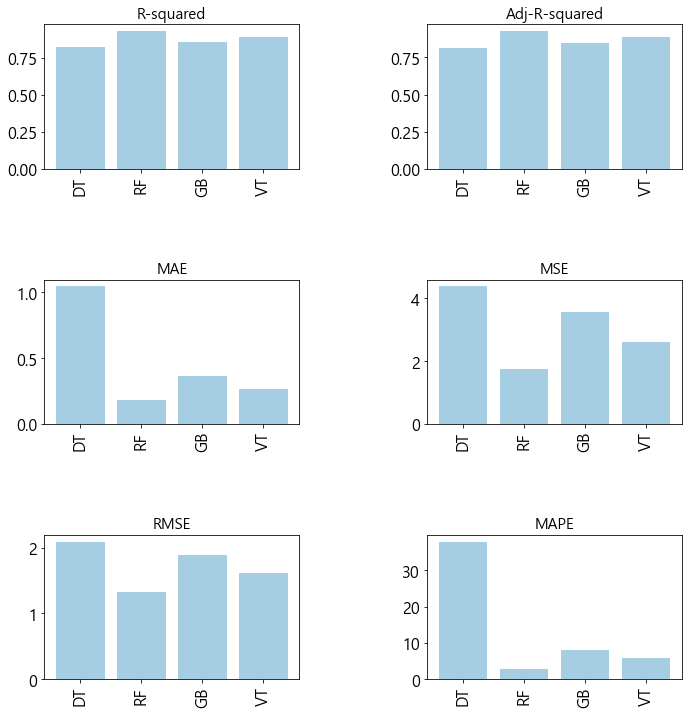

In [131]:
f, ax = plt.subplots(3, 2, figsize = (10, 10))
plt.tight_layout(w_pad = 5, h_pad = 5)

ax[0,0].bar(models_name, list(evaluate_df.loc['R-squared'].values))
ax[0,0].set_title("R-squared").set_fontsize(15)
ax[0,0].set_xticklabels(models_name, rotation=90)

ax[0,1].bar(models_name, list(evaluate_df.loc['Adj-R-squared'].values))
ax[0,1].set_title("Adj-R-squared").set_fontsize(15)
ax[0,1].set_xticklabels(models_name, rotation=90)

ax[1,0].bar(models_name, list(evaluate_df.loc['MAE'].values))
ax[1,0].set_title("MAE").set_fontsize(15)
ax[1,0].set_xticklabels(models_name, rotation=90)

ax[1,1].bar(models_name, list(evaluate_df.loc['MSE'].values))
ax[1,1].set_title("MSE").set_fontsize(15)
ax[1,1].set_xticklabels(models_name, rotation=90)

ax[2,0].bar(models_name, list(evaluate_df.loc['RMSE'].values))
ax[2,0].set_title("RMSE").set_fontsize(15)
ax[2,0].set_xticklabels(models_name, rotation=90)

ax[2,1].bar(models_name, list(evaluate_df.loc['MAPE'].values))
ax[2,1].set_title("MAPE").set_fontsize(15)
ax[2,1].set_xticklabels(models_name, rotation=90)

#### 최종모델의 학습시 중요 변수
- 상위 10개 중요 변수 선정.
- 최종 모델 RandomForest 모델 사용.

In [136]:
feature_name = x_train.columns
df_importance = pd.DataFrame()
df_importance["Feature"]    = feature_name
df_importance["Importance"] = best_model_list[1].feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)[:10]

,Feature,Importance
25,중상자수,0.271
24,사망자수,0.233
26,경상자수,0.190
4,사고내용,0.136
27,부상신고자수,0.060
15,피해자신체상해정도,0.020
11,가해자신체상해정도,0.009
2,발생지_시군구,0.008
29,시군구별_인구,0.007
17,가해차량용도_중분류,0.006


#### 라벨링 변수 다시 전환

In [138]:
df_re = pd.read_csv('total_data.csv')
df_re.head()

,Unnamed: 0,발생일,발생시간,발생지_시도,발생지_시군구,요일,사고내용,사고유형_대분류,사고유형_중분류,가해자법규위반,...,피해차량용도,기상상태,노면상태,사망자수,중상자수,경상자수,부상신고자수,응급실 개수,시군구별_인구,Risk
0,0,20170101,00시,경북,구미시,일,중상,차대차,추돌,안전운전 의무 불이행,...,승용차,맑음,건조,0,8,0,1,3,421012.0,25
1,1,20170101,02시,충남,홍성군,일,사망,차대차,추돌,안전운전 의무 불이행,...,승용차,맑음,건조,1,0,1,0,1,101025.0,13
2,2,20170101,03시,경북,상주시,일,경상,차대차,기타,안전운전 의무 불이행,...,렌터카,맑음,건조,0,0,2,0,2,100644.0,2
3,3,20170101,04시,서울,금천구,일,부상신고,차대차,측면충돌,기타,...,렌터카,맑음,젖음/습기,0,0,0,1,1,233960.0,1
4,4,20170101,07시,강원,강릉시,일,경상,차대차,추돌,안전운전 의무 불이행,...,승용차,맑음,건조,0,0,4,0,4,213450.0,4


#### 실제 데이터

In [143]:
df_index_train = list(df_re['발생지_시군구'][:8225].values)
df_train_result = pd.DataFrame()
df_train_result['Index'] = df_index_train
df_train_result['Risk']  = y_train
df_train_result['응급실_개수'] = df_re['응급실 개수'][:8225]
df_train_result['시군구별_인구'] = df_re['시군구별_인구'][:8225].astype('int64')
df_train_result.columns = ['발생지_시군구', 'Risk', '응급실_개수', '시군구별_인구']
df_train_result.to_csv('train1.csv', index=False)
df_train_result

,발생지_시군구,Risk,응급실_개수,시군구별_인구
0,구미시,25,3,421012
1,홍성군,13,1,101025
2,상주시,2,2,100644
3,금천구,1,1,233960
4,강릉시,4,4,213450
...,...,...,...,...
8220,군위군,6,0,23992
8221,유성구,3,1,349197
8222,용인시,6,4,1032939
8223,군위군,3,0,23992


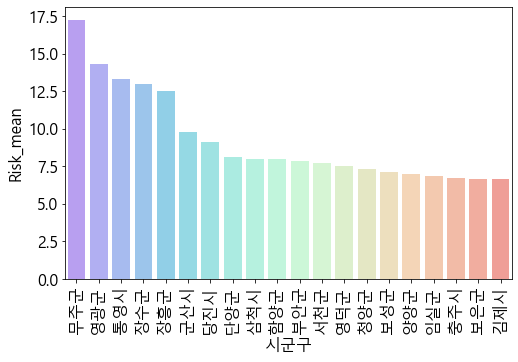

In [140]:
top20 = df_train_result.groupby('발생지_시군구').mean().sort_values(by='Risk', ascending=False)[:20]
sb.barplot(top20.index, [i[0] for i in top20.values], palette='rainbow', alpha=.5)
plt.xticks(rotation = 90)
plt.xlabel('시군구')
plt.ylabel('Risk_mean')
plt.show()

#### 예측 데이터

In [144]:
df_index = list(df_re['발생지_시군구'][8225:].values)
y_pred  = Vtreg.predict(x_test)
df_test_result = pd.DataFrame()
df_test_result['Index'] = df_index
df_test_result['Risk']  = y_pred
df_test_result['응급실_개수'] = list(df_re['응급실 개수'][8225:].values)
df_test_result['시군구별_인구'] = list(df_re['시군구별_인구'][8225:].astype('int64').values)
df_test_result.columns = ['발생지_시군구', 'Risk', '응급실 개수', '시군구별_인구']
df_test_result.to_csv('test1.csv', index=False)
df_test_result

,발생지_시군구,Risk,응급실 개수,시군구별_인구
0,양산시,3.829265,3,345978
1,유성구,1.067327,1,349197
2,울주군,2.003484,1,221909
3,강릉시,1.098438,4,213450
4,춘천시,8.475026,2,280815
...,...,...,...,...
4218,달서구,3.114486,6,573456
4219,하남시,1.073994,0,253119
4220,하남시,1.067327,0,253119
4221,화성시,4.979022,4,755068


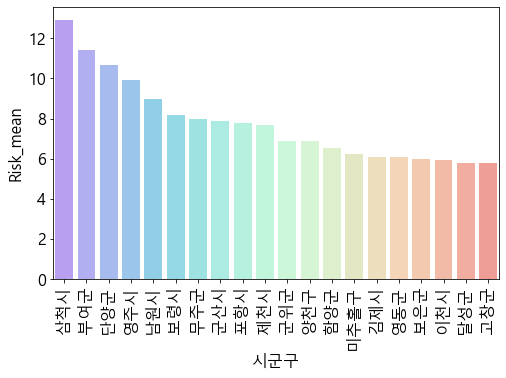

In [142]:
pred_top20 = df_test_result.groupby('발생지_시군구').mean().sort_values(by='Risk', ascending=False)[:20]
sb.barplot(pred_top20.index, [i[0] for i in pred_top20.values], palette='rainbow', alpha=.5)
plt.xticks(rotation = 90)
plt.xlabel('시군구')
plt.ylabel('Risk_mean')
plt.show()